In [1]:
using Optimisers, Zygote, Plots, Random, Distributions,TaylorDiff

SEED = 42
N_collocation_points = 100
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

rhs_function(x) = sin.(π * x)
analytical_solution(x) = sin(π * x) / π^2

rng = MersenneTwister(SEED)

sigmoid(x) = 1.0 / (1.0 + exp(-x))

# Initialize the weights according to the Xavier Glorot initializer
uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
W = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    HIDDEN_DEPTH,
    1,
)
V = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    1,
    HIDDEN_DEPTH,
)
b = zeros(HIDDEN_DEPTH)

parameters = (; W, V, b)

network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

x_line = reshape(collect(range(0.0f0, stop=1.0f0, length=100)), (1, 100))

# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

function network_forward_wrapper(x)
    return network_forward(x, parameters)[1]
end

function network_output_and_first_two_derivatives(x, p)
    f(x)=(p.V * sigmoid.(p.W * x .+ p.b))[1]
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (p.V .* p.W') * sigmoid_prime
    #second_derivative = (p.V .* p.W' .* p.W') * sigmoid_double_prime
    second_derivative = TaylorDiff.derivative.(f, x[:], Val(2))
    
    return output, first_derivative, second_derivative
end

_output, _first_derivative, _second_derivative = network_output_and_first_two_derivatives(x_line, parameters)

_zygote_first_derivative = Zygote.gradient(x -> sum(network_forward(x, parameters)), x_line)[1]

interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

boundary_collocation_points = [0.0 1.0]

function loss_forward(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss

    return total_loss
end

loss_forward(parameters)

out, back = Zygote.pullback(loss_forward, parameters)

back(1.0)[1]

opt = Adam(LEARNING_RATE)

opt_state = Optimisers.setup(opt, parameters)
loss_history = []
for i in 1:N_EPOCHS
    loss, back = Zygote.pullback(loss_forward, parameters)
    push!(loss_history, loss)
    grad, = back(1.0)
    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
    if i % 100 == 0
        println("Epoch: $i, Loss: $loss")
    end
end

Epoch: 100, Loss: 0.324183352203353
Epoch: 200, Loss: 0.27846109849911127
Epoch: 300, Loss: 0.2643988868461107
Epoch: 400, Loss: 0.26170487655600916
Epoch: 500, Loss: 0.26137176171666415
Epoch: 600, Loss: 0.26134064655402817
Epoch: 700, Loss: 0.2613338409493279
Epoch: 800, Loss: 0.2613277927546855
Epoch: 900, Loss: 0.26132121903291433
Epoch: 1000, Loss: 0.26131406735393586
Epoch: 1100, Loss: 0.2613063246445635
Epoch: 1200, Loss: 0.2612979751272357
Epoch: 1300, Loss: 0.26128899957211166
Epoch: 1400, Loss: 0.26127937532763634
Epoch: 1500, Loss: 0.2612690762478872
Epoch: 1600, Loss: 0.2612580725216006
Epoch: 1700, Loss: 0.26124633041014356
Epoch: 1800, Loss: 0.2612338118949417
Epoch: 1900, Loss: 0.26122047422958466
Epoch: 2000, Loss: 0.2612062693871989
Epoch: 2100, Loss: 0.26119114338915256
Epoch: 2200, Loss: 0.2611750354962909
Epoch: 2300, Loss: 0.26115787723832096
Epoch: 2400, Loss: 0.26113959125027936
Epoch: 2500, Loss: 0.261120089876767
Epoch: 2600, Loss: 0.26109927349425094
Epoch: 27

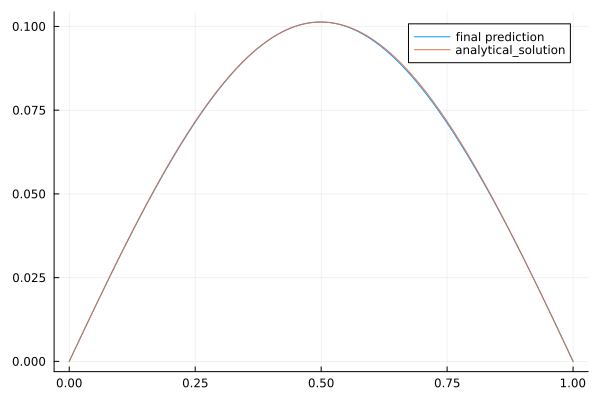

In [2]:
plot(x_line', network_forward(x_line, parameters)', label="final prediction")
plot!(x_line', analytical_solution.(x_line)', label="analytical_solution")

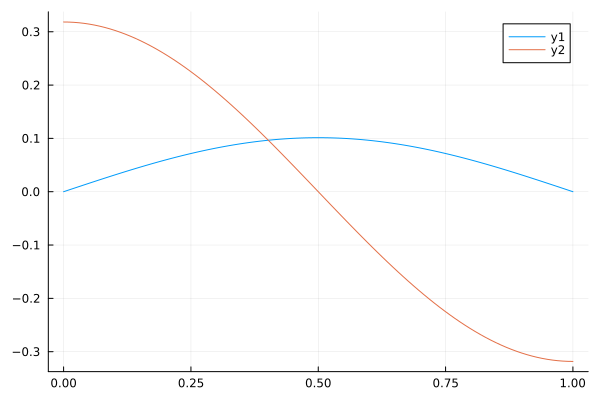

In [18]:
 
derivative1 = TaylorDiff.derivative.(analytical_solution, x_line[:], Val(1))
plot(x_line', analytical_solution.(x_line)')
plot!(x_line', derivative1)

In [14]:
nn(x) = network_forward(x, parameters)[1]

nn (generic function with 1 method)

In [15]:
derivative2 = TaylorDiff.derivative.(nn, x_line[:], Float32.(ones(size(x_line[:]))), Val(1))


100-element Vector{Float64}:
  0.31787596822868625
  0.31770272635374885
  0.3171560340170854
  0.3162493115201695
  0.3149956968642812
  0.31340787378966983
  0.3114979228798495
  0.30927720061789443
  0.3067562313137257
  0.3039446436518124
  ⋮
 -0.3051580961138773
 -0.30815060166628805
 -0.31095854415721996
 -0.31358641617464916
 -0.31603879509427785
 -0.31832032620567385
 -0.32043569483332607
 -0.32238966039033334
 -0.3241869676040714

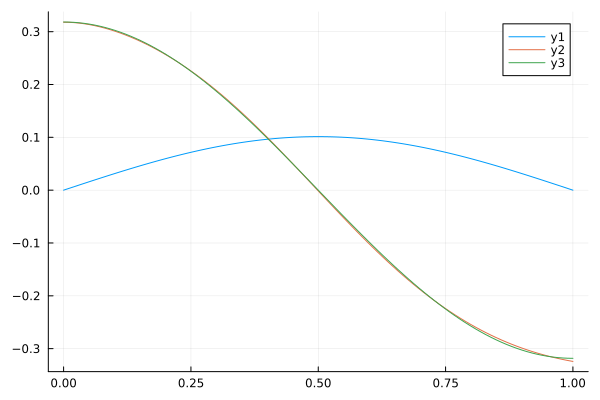

In [17]:
derivative2 = TaylorDiff.derivative.(nn, x_line[:], Float32.(ones(size(x_line[:]))), Val(1))
plot(x_line', analytical_solution.(x_line)')
plot!(x_line', derivative2)
plot!(x_line', derivative1)